<a href="https://colab.research.google.com/github/shakir507/BacklogModels/blob/main/ServiceBacklogModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The ideas in this model are based on Stermans book and Jim Duggans paper titled 'System dynamics modelling to support policy analysis
for sustainable health care'. The aim is to model backlogs in healthcare.

# The model

The model consists of backlog and resources as stock:
1. Backlog describing the que
2. Resources catering to the backlog.

There are auxilary variables that correspond to:
1. Input demand
2. Demand surge
3. Surge start and end
4. The time delay to process one patient in the healthcare system
5. Working hours in a day
6. Number of working days in a work week.
7. Productivity of each doctor.
8. Delay in hiring a resource/doctor
9. Attrition rate

Some variables are endogeneous:
10. Net Backlog dependent net hiring rate.


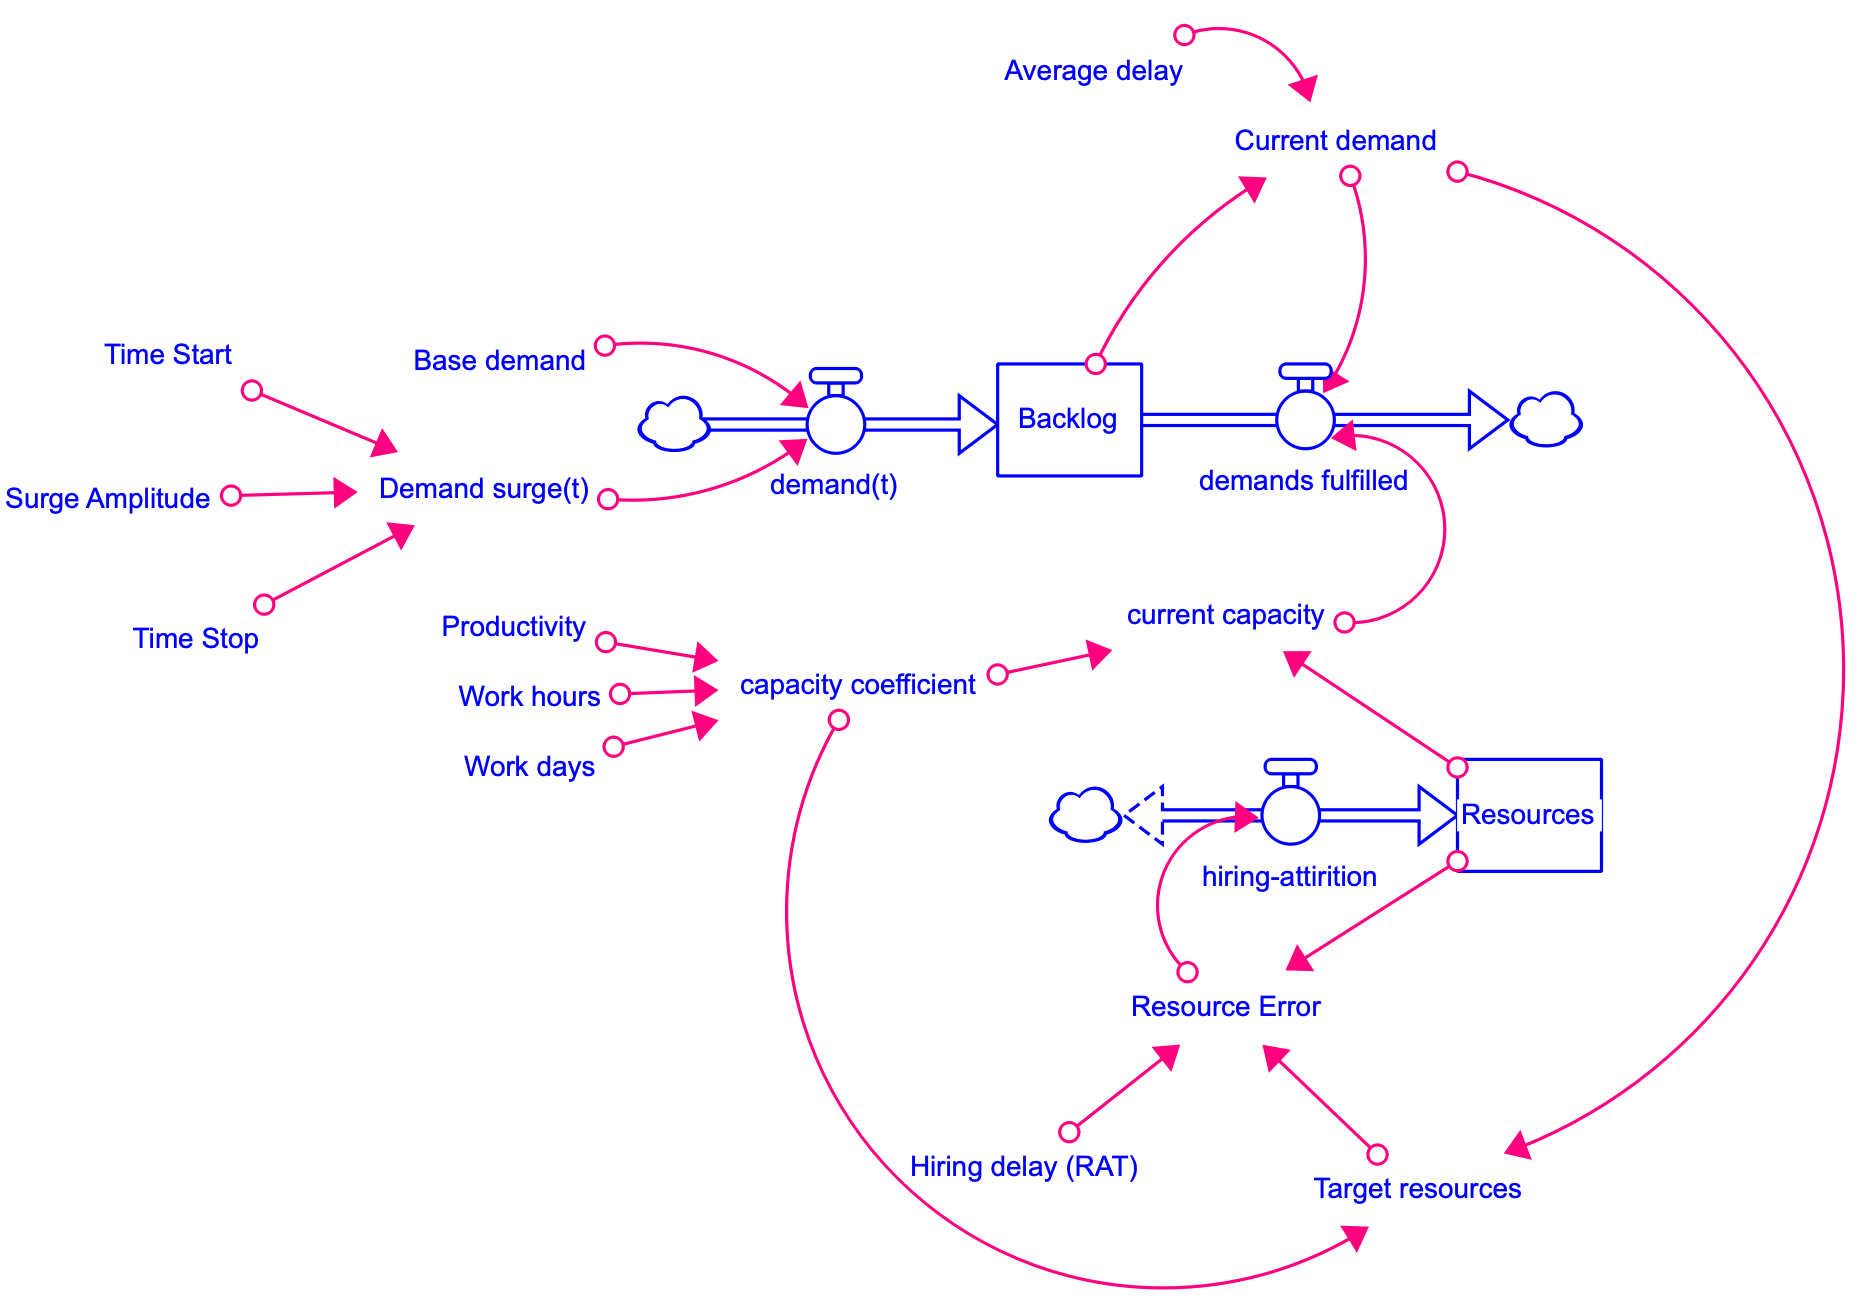

Fig 2. Causal Loop Diagram depicting the basic elements of a healthcare service backlog-resource model. The diagram highlights interactions between service backlogs, available resources, and demand, illustrating feedback key loops.

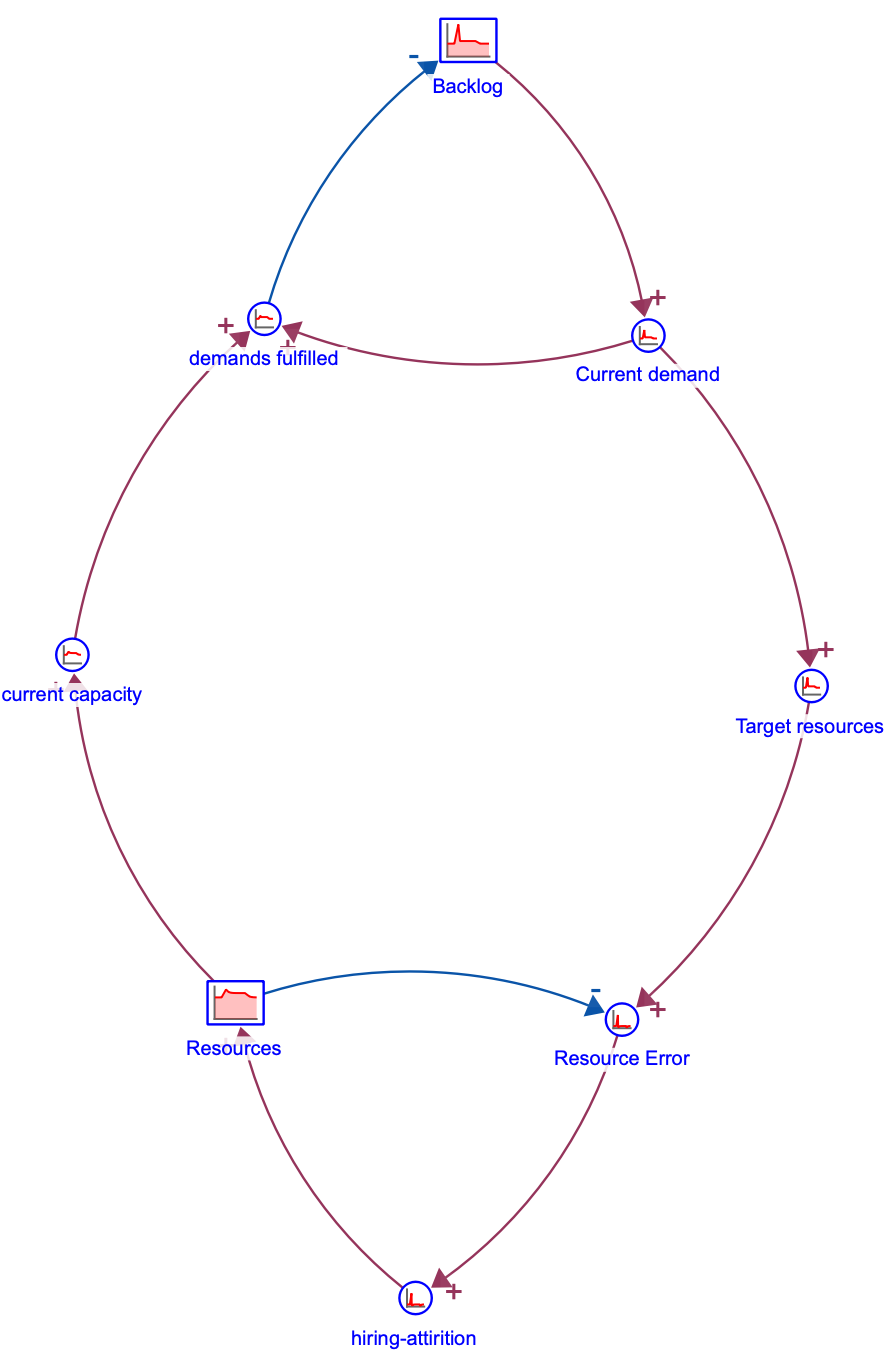


Fig 2: The CLD generated through Stella for service backlog model

The model equations are as follows:
1. B'=demand(t)-min(capacity, backlog/service delay)
2. R'= (Target resource - R)/hiring delay

# Python code
Simulation code in python

In [2]:
#Importing relevant libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [24]:

initial_backlog = 2  # Initial number of patients in the backlog
T0 = 1  # Initial time
Tf = 200  # Final time
time_span = (T0, Tf)  # Time range for simulation
time_points_backlog = np.linspace(time_span[0], time_span[1], 10000)  # Time points for evaluation
demandsurge = 600
basedemand = 100
period = 90  # Period of the surge
t1 = 50  # Start of the surge
t2 = t1 + period  # End of the surge
# counting number of time points between t1 and t2 based on time_points_backlog
timepoints_t1_t2 = time_points_backlog[(time_points_backlog >= t1) & (time_points_backlog <= t2)]
print("Number of time points between t1 and t2:", len(timepoints_t1_t2))
time_points_SIR = np.linspace(t1, t2, len(timepoints_t1_t2))  # Time points for evaluation

# Parameters for the SIR model
beta = 0.6  # Infection rate
gamma = 0.4  # Recovery rate
Ntot = 10000  # Total population
# -----------Parameters for resources
Wd = 5
Wh = 10
deliverydelay = 1 / 50
productivity = 1
R0 = 2
RAT = 1  # Resource Allocation Time
# -------------------------------------------

Number of time points between t1 and t2: 4522


In [25]:

# Define the time-dependent growth rate a(t)
def STEP(a0,t,t0):
    return a0*np.heaviside(t-t0,0)


def SIR(t, Y, beta, gamma):
    S, I, R = Y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def solve_SIR_direct(t1, t2):
    # Solve the SIR model only between t1 and t2
    time_span = (t1, t2)
    time_points = np.linspace(t1, t2, 1000)  # Time points for evaluation
    S0 = 1 - 1 / Ntot  # Initial susceptible population
    I0 = 1 / Ntot  # Initial infected population
    R0 = 0.0  # Initial recovered population
    Initial_conditions = [S0, I0, R0]
    solution = solve_ivp(
        SIR,
        time_span,
        Initial_conditions,
        t_eval=time_points,
        args=(beta, gamma),
        rtol=1e-6,
        atol=1e-6
    )
    solution.y[1] *= Ntot  # Scale infected population to actual size
    return time_points, solution.y[1]  # Return time points and infected population


In [26]:

def demandsurge_function(fn=1):
    if fn == 1 or fn == 2:
        return demandsurge
    if fn == 3:
        t_sir, I_sir = solve_SIR_direct(t1, t2)  # Get time points and infected population
        return t_sir, I_sir

def demand(t, delta, fn=1):
    if fn == 1:
        return basedemand + STEP(delta, t, t1) - STEP(delta, t, t1 + period)  # Square wave
    if fn == 2:
        return basedemand + (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period))) * STEP(1, t, t1) - STEP(1, t, t1 + period) * (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period)))  # Sinusoidal
    elif fn == 3:  # SIR-based demand
        t_sir, I_sir = delta  # Unpack time points and infected population
        if t < t1:  # Constant demand before t1
            return basedemand
        elif t > t2:  # Constant demand after t2
            return basedemand
        else:  # Use SIR dynamics between t1 and t2
            idx = np.searchsorted(t_sir, t)  # Find the closest SIR time point
            return basedemand + I_sir[idx]


In [27]:

def resources(t, dCp):
    # Using Heaviside for step functions
    dNr = dCp / (Wd * Wh)
    return dNr

def resource_error(t, Cp, C):
    return (Cp - C) / (Wh * Wd * productivity)


In [28]:

# Define the ODE for customer growth
def backloghospital(t, Y, demandsurge, fn=1):
    B, R = Y
    a = demand(t, demandsurge_function(fn), fn)  # Get the time-dependent growth rate
    MaximumDemandFullfilled = B / deliverydelay
    C0 = R * Wd * Wh
    C = C0
    Cp = MaximumDemandFullfilled  # Target capacity required to meet backlog demand
    d = min(MaximumDemandFullfilled, C)  # Demand met
    dB_dt = a - d  # Change in backlog based on demand met and demand and demand surge
    dR_dt = (resource_error(t, Cp, C)) / RAT  # Change in resources based on shortage or surplus of resources to meet demand
    return [dB_dt, dR_dt]

In [29]:
print("Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge")
fn = int(input("Enter the surge functional form:"))
# Solve the ODE
solution = solve_ivp(
    backloghospital,          # ODE function
    time_span,                # Time span
    [initial_backlog, 2],     # Initial condition
    t_eval=time_points_backlog,       # Time points to evaluate the solution
    args=(demandsurge, fn,),  # Additional arguments for the ODE function
    rtol=1e-6,  # Reduce relative tolerance
    atol=1e-6   # Reduce absolute tolerance
)

Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge
Enter the surge functional form:1


In [30]:

# Extract results
time = solution.t
backlog = solution.y[0]
resources = solution.y[1]


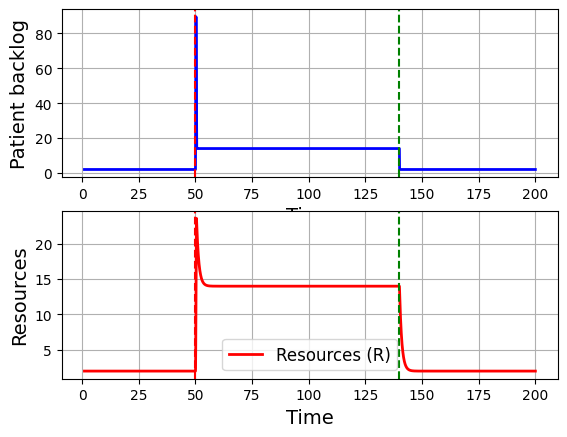

In [31]:

# Plot backlog and resources in subplots
fig, ax = plt.subplots(2)
ax[0].plot(time, backlog, label="Backlog (B)", color="blue", linewidth=2)
ax[0].axvline(t1, color="red", linestyle="--")
ax[0].axvline(t2, color="green", linestyle="--")
ax[0].set_xlabel("Time", fontsize=14)
ax[0].set_ylabel("Patient backlog", fontsize=14)
ax[1].plot(time, resources, label="Resources (R)", color="red", linewidth=2)
ax[1].axvline(t1, color="red", linestyle="--")
ax[1].axvline(t2, color="green", linestyle="--")
ax[1].set_xlabel("Time", fontsize=14)
ax[1].set_ylabel("Resources", fontsize=14)
plt.legend(fontsize=12)
ax[0].grid(True)
ax[1].grid(True)

# plt.show()


In [32]:
print("Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge")
fn = int(input("Enter the surge functional form:"))
# Solve the ODE
solution = solve_ivp(
    backloghospital,          # ODE function
    time_span,                # Time span
    [initial_backlog, 2],     # Initial condition
    t_eval=time_points_backlog,       # Time points to evaluate the solution
    args=(demandsurge, fn,),  # Additional arguments for the ODE function
    rtol=1e-6,  # Reduce relative tolerance
    atol=1e-6   # Reduce absolute tolerance
)

Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge
Enter the surge functional form:2


In [33]:

# Extract results
time = solution.t
backlog = solution.y[0]
resources = solution.y[1]


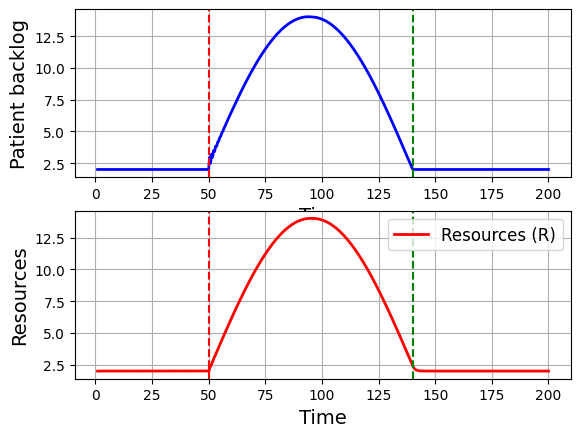

In [34]:

# Plot backlog and resources in subplots
fig, ax = plt.subplots(2)
ax[0].plot(time, backlog, label="Backlog (B)", color="blue", linewidth=2)
ax[0].axvline(t1, color="red", linestyle="--")
ax[0].axvline(t2, color="green", linestyle="--")
ax[0].set_xlabel("Time", fontsize=14)
ax[0].set_ylabel("Patient backlog", fontsize=14)
ax[1].plot(time, resources, label="Resources (R)", color="red", linewidth=2)
ax[1].axvline(t1, color="red", linestyle="--")
ax[1].axvline(t2, color="green", linestyle="--")
ax[1].set_xlabel("Time", fontsize=14)
ax[1].set_ylabel("Resources", fontsize=14)
plt.legend(fontsize=12)
ax[0].grid(True)
ax[1].grid(True)

# plt.show()


In [35]:
print("Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge")
fn = int(input("Enter the surge functional form:"))
# Solve the ODE
solution = solve_ivp(
    backloghospital,          # ODE function
    time_span,                # Time span
    [initial_backlog, 2],     # Initial condition
    t_eval=time_points_backlog,       # Time points to evaluate the solution
    args=(demandsurge, fn,),  # Additional arguments for the ODE function
    rtol=1e-6,  # Reduce relative tolerance
    atol=1e-6   # Reduce absolute tolerance
)

Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge
Enter the surge functional form:3


In [36]:

# Extract results
time = solution.t
backlog = solution.y[0]
resources = solution.y[1]


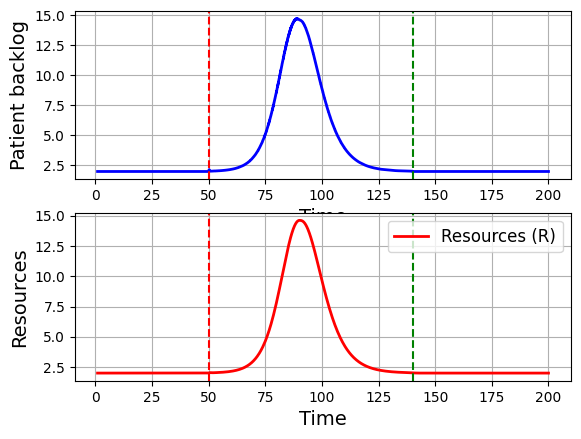

In [37]:

# Plot backlog and resources in subplots
fig, ax = plt.subplots(2)
ax[0].plot(time, backlog, label="Backlog (B)", color="blue", linewidth=2)
ax[0].axvline(t1, color="red", linestyle="--")
ax[0].axvline(t2, color="green", linestyle="--")
ax[0].set_xlabel("Time", fontsize=14)
ax[0].set_ylabel("Patient backlog", fontsize=14)
ax[1].plot(time, resources, label="Resources (R)", color="red", linewidth=2)
ax[1].axvline(t1, color="red", linestyle="--")
ax[1].axvline(t2, color="green", linestyle="--")
ax[1].set_xlabel("Time", fontsize=14)
ax[1].set_ylabel("Resources", fontsize=14)
plt.legend(fontsize=12)
ax[0].grid(True)
ax[1].grid(True)

# plt.show()
